In [1]:
import pandas as pd

df = pd.read_csv("baseball_preprocessed.csv")

In [2]:
df

,date,article
0,20220101,정지택 KBO 총재가 신년사를 통해 2022시즌 스트라이크 존 개선 등 경기력 향상...
1,20220101,KBO 정지택 총재가 1일 신년사를 통해 급변하는 스포츠산업에 발맞춰 선수들의 이미...
2,20220101,KBO리그는 2022년 '불혹'을 맞이했다. 지난 1982년 출범한 KBO리그는 올...
3,20220101,KBO리그가 출범 40년째를 맞이했다. 정지택 총재는 신년사를 통해 다양한 개선안을...
4,20220101,지난해 10월 30일 창원 삼성-NC전. 삼성은 6-4로 앞선 6회초 공격 때 오선...
...,...,...
6655,20230101,피츠버그 파이리츠 최지만이 KBO리그 선수 중 메이저리그에서 통할 수 있는 선수 두...
6656,20230101,프로 팀이라면 늘 승리를 추구해야 한다. 우승이 궁극적 목표이지만 팀마다 속도 조절...
6657,20230101,야구 인기를 회복할 절호의 찬스가 찾아왔다. 쉽지 않지만 기회를 살린다면 다시 한 ...
6658,20230101,제5회 WBC 3월9일부터… 코로나로 5년 만에 대회 日·濠·中·체코 함께 B조… ...


In [3]:
sentences = []

In [4]:
from konlpy.tag import Mecab

mecab = Mecab()

In [92]:
from tqdm import tqdm
selected_tags = ["NNG", "NNP", "VA"]
sentences = []
for i in tqdm(range(len(df))):
    article = df.iloc[i]["article"]
    tokens = mecab.pos(article)
    filtered_tokens = [word  for word, pos in tokens if pos in selected_tags]
    sentences.append(filtered_tokens)

100%|███████████████████████████████████████████████████████| 6660/6660 [00:05<00:00, 1113.37it/s]


## 선수별 함께 등장하는 단어 word cloud 시각화

In [93]:
player_name = "이정후"

In [94]:
from collections import Counter


def count_words_by_player(player_name):
    c = Counter()
    for sentence in sentences:
        if player_name in sentence:
            c += Counter(sentence)
    del c[player_name]
    return c

In [129]:
from wordcloud import WordCloud

def visualize_wordcloud(word_count):
    wordcloud = WordCloud(
        font_path="/Library/Fonts/NanumGothic.otf",
        width=1000, 
        height=400, 
        scale=2.0, 
        background_color='white', 
        colormap='Reds',
        max_font_size=150
    ).generate_from_frequencies(word_count)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud)

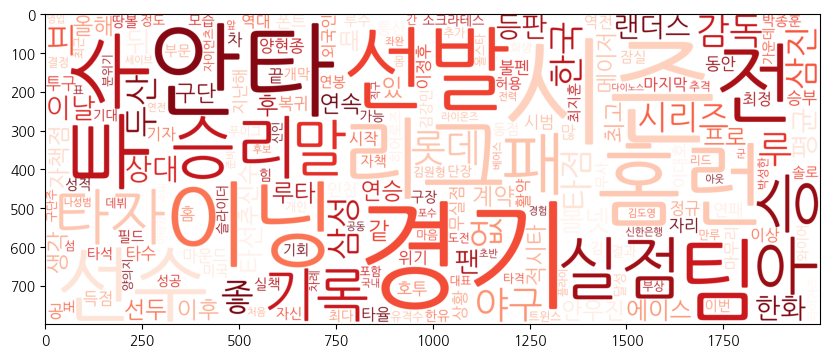

In [133]:
word_count = count_words_by_player("김광현")
visualize_wordcloud(word_count)

## Word2Vec 모델을 이용한 word embedding 학습
- gensim 라이브러리가 제공하는 word2vec 학습 코드를 이용해서 word embedding 학습 

In [6]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=sentences, vector_size=128, window = 10, min_count = 5, workers = 4, sg = 0).wv

In [7]:
model.most_similar("김광현")

[('폰트', 0.7175672054290771),
 ('추신수', 0.6879918575286865),
 ('윌머', 0.6773003935813904),
 ('양현종', 0.661933958530426),
 ('노바', 0.6516246795654297),
 ('이반', 0.5898649096488953),
 ('에이스', 0.5506199598312378),
 ('오원석', 0.5398542284965515),
 ('랜더스', 0.5331763625144958),
 ('켈리', 0.5284693837165833)]

In [52]:
import csv
from collections import defaultdict


def parse_players(players_str):
    return  [x.split("(")[0] for x in players_str.split("\n")]

with open("players_with_labels.csv") as fr:
    reader = csv.reader(fr)
    next(reader)
    total_players = []
    player_team_dict = {}
    player_position_dict = {}
    
    def _add_player_dict(team, position, players):
        for player in players:
            total_players.append(player)
            player_team_dict[player] = team
            player_position_dict[player] = position
            
    for i, row in enumerate(reader):
        team, pitcher_str, catcher_str, infielder_str, outfielder_str = row
        pitchers = pitcher_str.split("\n")
        catchers = catcher_str.split("\n")
        infielders = infielder_str.split("\n")
        outfielders = outfielder_str.split("\n")
        _add_player_dict(team, "투수", pitchers)
        _add_player_dict(team, "포수", catchers)
        _add_player_dict(team, "내야수", infielders)
        _add_player_dict(team, "외야수", outfielders)

In [53]:
vocabs = set(model.index_to_key)
filtered_players = [player for player in total_players if player in vocabs]

## 임베딩 벡터 차원 축소

In [54]:
import numpy as np

word_vectors = np.array([model[player] for player in filtered_players])

In [55]:
len(filtered_players)

214

In [56]:
word_vectors.shape

(214, 128)

In [57]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(word_vectors)

# 전체 선수 임베딩 벡터 scatter plot

Text(0.5, 1.0, '야구 선수 워드 임베딩 벡터 시각화')

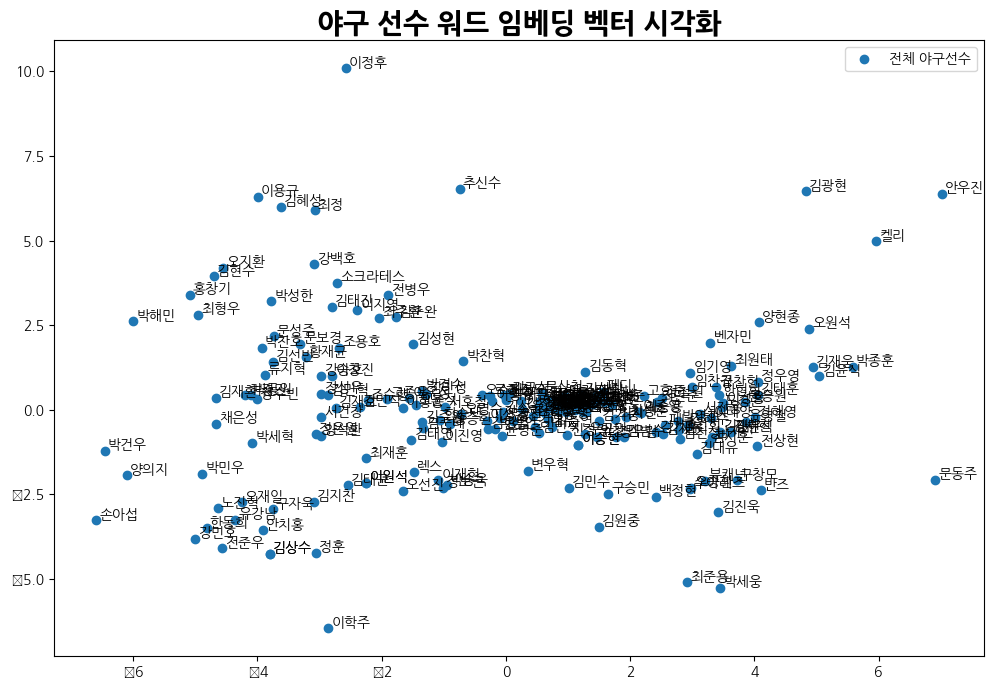

In [84]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.rc('font', family='NanumGothicOTF') 
plt.figure(figsize=(12, 8))
plt.scatter(reduced_vectors[:,0], reduced_vectors[:,1], label="전체 야구선수")
for word, (x,y) in zip(filtered_players, reduced_vectors):
    plt.text(x+0.05, y+0.05, word)
plt.legend()
plt.title("야구 선수 워드 임베딩 벡터 시각화", fontweight='bold', fontsize=20)

# 팀 별 임베딩 벡터 시각화

In [59]:
unique_teams = set(list(player_team_dict.values()))

In [60]:
# 팀이 주어졌을 때, 그 팀 소속 선수들의 인덱스 가져오기
def player_index_by_team(team, players):
    indices = []
    for i, player in enumerate(players):
        if player_team_dict[player] == team:
            indices.append(i)
    return indices

Text(0.5, 1.0, '야구 선수 팀별 워드 임베딩 벡터 시각화')

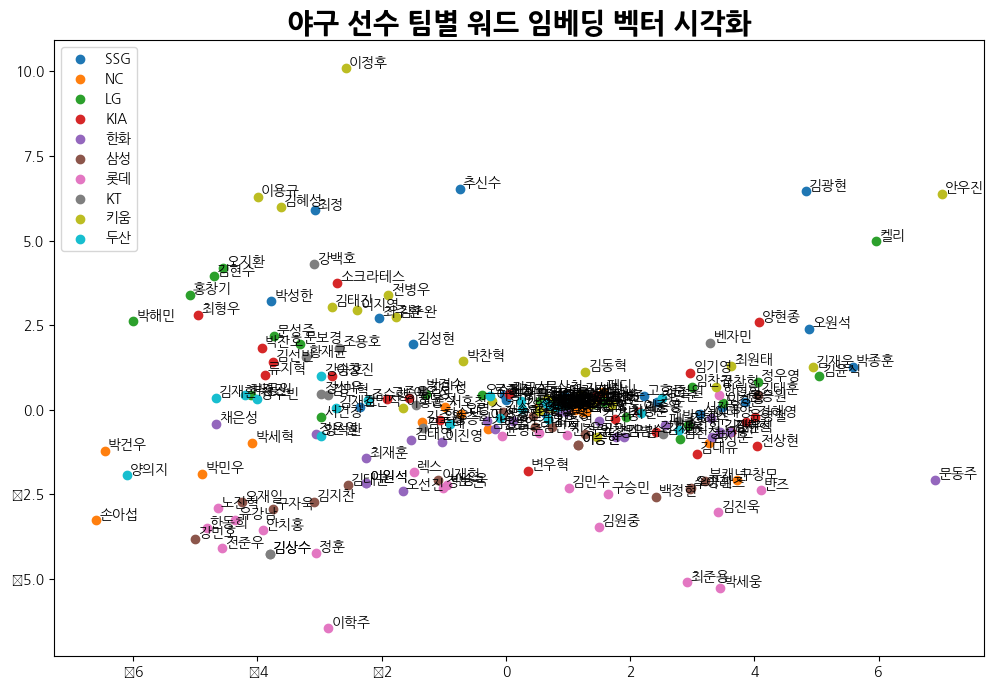

In [82]:
plt.figure(figsize=(12, 8))
for team in unique_teams:
    player_indices = player_index_by_team(team, filtered_players)
    player_names = [filtered_players[i] for i in player_indices]
    player_vectors = reduced_vectors[player_indices]
    
    plt.scatter(player_vectors[:,0], player_vectors[:,1], label=team)
    for word, (x,y) in zip(player_names, player_vectors):
        plt.text(x+0.05, y+0.05, word)
plt.legend()
plt.title("야구 선수 팀별 워드 임베딩 벡터 시각화", fontweight='bold', fontsize=20)

## 포지션 별 임베딩 벡터 시각화

In [67]:
unique_positions = set(list(player_position_dict.values()))

In [68]:
# 팀이 주어졌을 때, 그 팀 소속 선수들의 인덱스 가져오기
def player_index_by_position(position, players):
    indices = []
    for i, player in enumerate(players):
        if player_position_dict[player] == position:
            indices.append(i)
    return indices

Text(0.5, 1.0, '야구 선수 포지션별 워드 임베딩 벡터 시각화')

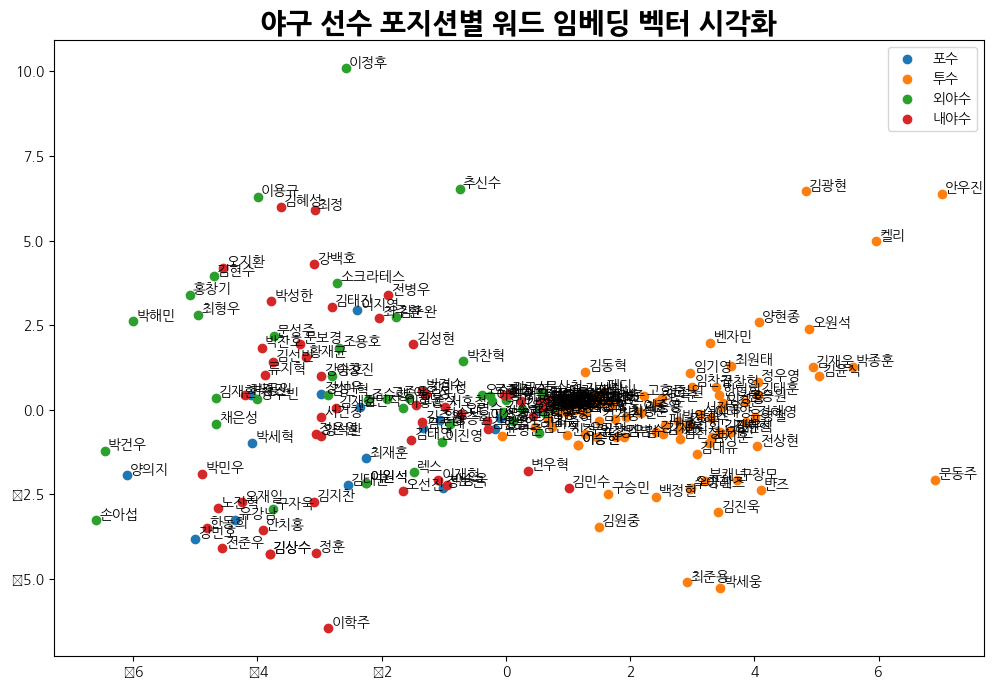

In [81]:
plt.figure(figsize=(12, 8))
for position in unique_positions:
    player_indices = player_index_by_position(position, filtered_players)
    player_names = [filtered_players[i] for i in player_indices]
    player_vectors = reduced_vectors[player_indices]
    
    plt.scatter(player_vectors[:,0], player_vectors[:,1], label=position)
    for word, (x,y) in zip(player_names, player_vectors):
        plt.text(x+0.05, y+0.05, word)
plt.legend()
plt.title("야구 선수 포지션별 워드 임베딩 벡터 시각화", fontweight='bold', fontsize=20)